In [ ]:
# %%capture
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"bibekchalise","key":"53b5557999a6db293e648ba8d77affc6"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset

 96% 232M/242M [00:01<00:00, 289MB/s]
100% 242M/242M [00:01<00:00, 230MB/s]


In [ ]:
!ls

 5-flower-types-classification-dataset.zip   kaggle.json
'kaggle (1).json'			     sample_data


In [ ]:
%%capture
!unzip 5-flower-types-classification-dataset.zip

In [ ]:
data_dir = '/content/flower_images'

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import glob, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch.nn as nn
!pip install torch_summary
from torchvision import transforms, models, datasets
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
path = glob.glob(data_dir+'/*/*')

In [ ]:
df = pd.DataFrame(path, columns=['path'])

In [ ]:
df['label'] = df['path'].apply(lambda x: x.split('/')[-2])

In [ ]:
df

,path,label
0,/content/flower_images/Orchid/e67e5ee3ef.jpg,Orchid
1,/content/flower_images/Orchid/ff7f9acb69.jpg,Orchid
2,/content/flower_images/Orchid/1c81df0661.jpg,Orchid
3,/content/flower_images/Orchid/5c307bc9c1.jpg,Orchid
4,/content/flower_images/Orchid/102f1b77ea.jpg,Orchid
...,...,...
4995,/content/flower_images/Lotus/0c58cee30f.jpg,Lotus
4996,/content/flower_images/Lotus/de8ad9aa08.jpg,Lotus
4997,/content/flower_images/Lotus/eb32def629.jpg,Lotus
4998,/content/flower_images/Lotus/b768a0fb74.jpg,Lotus


In [ ]:
df.label.value_counts()

Orchid       1000
Lilly        1000
Sunflower    1000
Tulip        1000
Lotus        1000
Name: label, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.label = le.fit_transform(df.label)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Lilly': 0, 'Lotus': 1, 'Orchid': 2, 'Sunflower': 3, 'Tulip': 4}


In [ ]:
df

,path,label
0,/content/flower_images/Orchid/e67e5ee3ef.jpg,2
1,/content/flower_images/Orchid/ff7f9acb69.jpg,2
2,/content/flower_images/Orchid/1c81df0661.jpg,2
3,/content/flower_images/Orchid/5c307bc9c1.jpg,2
4,/content/flower_images/Orchid/102f1b77ea.jpg,2
...,...,...
4995,/content/flower_images/Lotus/0c58cee30f.jpg,1
4996,/content/flower_images/Lotus/de8ad9aa08.jpg,1
4997,/content/flower_images/Lotus/eb32def629.jpg,1
4998,/content/flower_images/Lotus/b768a0fb74.jpg,1


In [ ]:
df.label.value_counts()

2    1000
0    1000
3    1000
4    1000
1    1000
Name: label, dtype: int64

In [ ]:
class FlowerDataset(Dataset):
  def __init__(self, df):
    self.df = df
    self.fpaths = df.path
    self.targets = df.label

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):

        f = self.fpaths[ix]
        target = (self.targets[ix])
        im = cv2.imread(f)[:,:,::-1]
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor(target).long().to(device)


In [ ]:
data = FlowerDataset(df)

In [ ]:
im, label = data[100]

tensor(2, device='cuda:0')


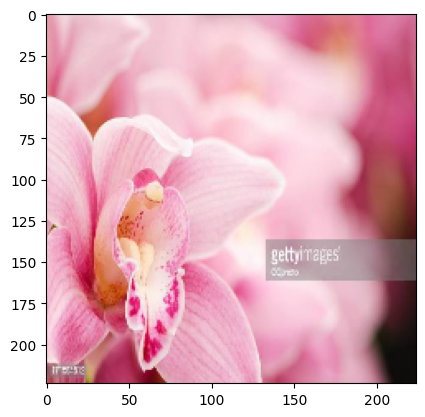

In [ ]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
train_df, val_df = train_test_split(df, stratify=df.label, random_state=42)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
def conv_layer(ni, no, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

In [ ]:
def get_model():
  model = nn.Sequential(
      conv_layer(3,64,3),
      conv_layer(64,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      nn.Flatten(),
      nn.Linear(512,5),
      nn.Sigmoid(),
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [ ]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [ ]:
def get_data():
  train = FlowerDataset(train_df)
  trn_dl = DataLoader(train, batch_size=16,shuffle=True, drop_last=True)
  val = FlowerDataset(val_df)
  val_dl = DataLoader(val, batch_size=26, shuffle=True, drop_last=True)
  return trn_dl, val_dl

In [ ]:
def train_batch(x, y, model,  loss_fn,opt):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  pred = model(x)
  _, is_correct = torch.max(pred.data,1)
  acc_all = (is_correct==y).detach().cpu().numpy()
  return acc_all

In [ ]:
@torch.no_grad()
def val_loss_trn(x, y, model, loss_fn):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)

  return val_loss.item()

In [ ]:
trn_ldr, test_ldr = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
import time
from tqdm import tqdm
start_time = time.time()

train_loss = []
train_accuracies= []
val_loss = []
val_accuracies = []

for i in range(25):
  print(f'Epoch: _________*****{i}*****_______')
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies, val_epoch_losses = [], []



  for ix, batch in tqdm((enumerate(iter(trn_ldr))), total=len(trn_ldr)):
      x, y = batch
      train_epoch_losses.append(train_batch(x, y, model, loss_fn, optimizer))
  train_epoch_loss = np.array(train_epoch_losses).mean()
  print(f'Epoch: _________*****{i} Training Loss : {train_epoch_loss} *****_______')



  for ix, batch in tqdm((enumerate(iter(trn_ldr))), total=len(trn_ldr)):
    x, y = batch
    train_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  train_epoch_accuracy = np.array(train_epoch_accuracies).mean()
  print(f'Epoch: _________*****{i} Training Accuracy: {train_epoch_accuracy} *****_______')



  for ix, batch in tqdm((enumerate(iter(test_ldr))), total=len(test_ldr)):
    x, y = batch
    val_epoch_losses.append(val_loss_trn(x, y, model, loss_fn))
  val_epoch_loss = np.array(val_epoch_losses).mean()
  print(f'Epoch: _________*****{i} Validation Loss : {val_epoch_loss} *****_______')

  for ix, batch in tqdm((enumerate(iter(test_ldr))), total=len(test_ldr)):
    x, y = batch
    val_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  val_epoch_accuracy = np.array(val_epoch_accuracies).mean()
  print(f'Epoch: _________*****{i} Validation Accuracy. {val_epoch_accuracy} *****_______')
  print('\n')

  train_loss.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)
  val_loss.append(val_epoch_loss)

Epoch: _________*****0*****_______


100%|██████████| 234/234 [01:27<00:00,  2.68it/s]


Epoch: _________*****0 Training Loss : 1.3735474755621364 *****_______


100%|██████████| 234/234 [00:51<00:00,  4.55it/s]


Epoch: _________*****0 Training Accuracy: 0.5590277777777778 *****_______


100%|██████████| 48/48 [00:17<00:00,  2.81it/s]


Epoch: _________*****0 Validation Loss : 1.3285854508479435 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.85it/s]


Epoch: _________*****0 Validation Accuracy. 0.5416666666666666 *****_______


Epoch: _________*****1*****_______


100%|██████████| 234/234 [01:22<00:00,  2.83it/s]


Epoch: _________*****1 Training Loss : 1.3049240474008088 *****_______


100%|██████████| 234/234 [00:49<00:00,  4.72it/s]


Epoch: _________*****1 Training Accuracy: 0.5884081196581197 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.86it/s]


Epoch: _________*****1 Validation Loss : 1.287160928050677 *****_______


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: _________*****1 Validation Accuracy. 0.5849358974358974 *****_______


Epoch: _________*****2*****_______


100%|██████████| 234/234 [01:20<00:00,  2.90it/s]


Epoch: _________*****2 Training Loss : 1.27444761685836 *****_______


100%|██████████| 234/234 [00:49<00:00,  4.75it/s]


Epoch: _________*****2 Training Accuracy: 0.6426282051282052 *****_______


100%|██████████| 48/48 [00:17<00:00,  2.82it/s]


Epoch: _________*****2 Validation Loss : 1.2577435746788979 *****_______


100%|██████████| 48/48 [00:17<00:00,  2.82it/s]


Epoch: _________*****2 Validation Accuracy. 0.6025641025641026 *****_______


Epoch: _________*****3*****_______


100%|██████████| 234/234 [01:20<00:00,  2.90it/s]


Epoch: _________*****3 Training Loss : 1.2531650254869053 *****_______


100%|██████████| 234/234 [00:47<00:00,  4.89it/s]


Epoch: _________*****3 Training Accuracy: 0.6474358974358975 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.82it/s]


Epoch: _________*****3 Validation Loss : 1.2624201650420825 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.99it/s]


Epoch: _________*****3 Validation Accuracy. 0.6033653846153846 *****_______


Epoch: _________*****4*****_______


100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch: _________*****4 Training Loss : 1.2281550887303474 *****_______


100%|██████████| 234/234 [00:47<00:00,  4.97it/s]


Epoch: _________*****4 Training Accuracy: 0.6669337606837606 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.96it/s]


Epoch: _________*****4 Validation Loss : 1.2387111062804859 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.88it/s]


Epoch: _________*****4 Validation Accuracy. 0.6354166666666666 *****_______


Epoch: _________*****5*****_______


100%|██████████| 234/234 [01:19<00:00,  2.96it/s]


Epoch: _________*****5 Training Loss : 1.2087199471445165 *****_______


100%|██████████| 234/234 [00:47<00:00,  4.92it/s]


Epoch: _________*****5 Training Accuracy: 0.6856303418803419 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.97it/s]


Epoch: _________*****5 Validation Loss : 1.2152416706085205 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.88it/s]


Epoch: _________*****5 Validation Accuracy. 0.6354166666666666 *****_______


Epoch: _________*****6*****_______


100%|██████████| 234/234 [01:19<00:00,  2.94it/s]


Epoch: _________*****6 Training Loss : 1.1868538757165272 *****_______


100%|██████████| 234/234 [00:47<00:00,  4.91it/s]


Epoch: _________*****6 Training Accuracy: 0.7232905982905983 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.95it/s]


Epoch: _________*****6 Validation Loss : 1.2032991821567218 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.87it/s]


Epoch: _________*****6 Validation Accuracy. 0.6538461538461539 *****_______


Epoch: _________*****7*****_______


100%|██████████| 234/234 [01:18<00:00,  2.98it/s]


Epoch: _________*****7 Training Loss : 1.1622016924059289 *****_______


100%|██████████| 234/234 [00:47<00:00,  4.88it/s]


Epoch: _________*****7 Training Accuracy: 0.7863247863247863 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.96it/s]


Epoch: _________*****7 Validation Loss : 1.1874459783236186 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.95it/s]


Epoch: _________*****7 Validation Accuracy. 0.6979166666666666 *****_______


Epoch: _________*****8*****_______


100%|██████████| 234/234 [01:19<00:00,  2.95it/s]


Epoch: _________*****8 Training Loss : 1.1431820555629892 *****_______


100%|██████████| 234/234 [00:47<00:00,  4.95it/s]


Epoch: _________*****8 Training Accuracy: 0.7975427350427351 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.89it/s]


Epoch: _________*****8 Validation Loss : 1.1689495692650478 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.95it/s]


Epoch: _________*****8 Validation Accuracy. 0.7131410256410255 *****_______


Epoch: _________*****9*****_______


100%|██████████| 234/234 [01:19<00:00,  2.95it/s]


Epoch: _________*****9 Training Loss : 1.1141549565343776 *****_______


100%|██████████| 234/234 [00:47<00:00,  4.94it/s]


Epoch: _________*****9 Training Accuracy: 0.8181089743589743 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.84it/s]


Epoch: _________*****9 Validation Loss : 1.1564391156037648 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.96it/s]


Epoch: _________*****9 Validation Accuracy. 0.7123397435897436 *****_______


Epoch: _________*****10*****_______


100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch: _________*****10 Training Loss : 1.0978480144443674 *****_______


100%|██████████| 234/234 [00:47<00:00,  4.95it/s]


Epoch: _________*****10 Training Accuracy: 0.8482905982905983 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.97it/s]


Epoch: _________*****10 Validation Loss : 1.1403110387424629 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.94it/s]


Epoch: _________*****10 Validation Accuracy. 0.7467948717948717 *****_______


Epoch: _________*****11*****_______


100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch: _________*****11 Training Loss : 1.0905066214056096 *****_______


100%|██████████| 234/234 [00:46<00:00,  4.99it/s]


Epoch: _________*****11 Training Accuracy: 0.8490918803418803 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.97it/s]


Epoch: _________*****11 Validation Loss : 1.1492840175827344 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.89it/s]


Epoch: _________*****11 Validation Accuracy. 0.7259615384615384 *****_______


Epoch: _________*****12*****_______


100%|██████████| 234/234 [01:18<00:00,  2.99it/s]


Epoch: _________*****12 Training Loss : 1.1508607449185135 *****_______


100%|██████████| 234/234 [00:46<00:00,  5.00it/s]


Epoch: _________*****12 Training Accuracy: 0.8384081196581197 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.98it/s]


Epoch: _________*****12 Validation Loss : 1.1432678575317066 *****_______


100%|██████████| 48/48 [00:15<00:00,  3.02it/s]


Epoch: _________*****12 Validation Accuracy. 0.7395833333333334 *****_______


Epoch: _________*****13*****_______


100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch: _________*****13 Training Loss : 1.11155012402779 *****_______


100%|██████████| 234/234 [00:46<00:00,  5.01it/s]


Epoch: _________*****13 Training Accuracy: 0.6330128205128205 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.90it/s]


Epoch: _________*****13 Validation Loss : 1.2984097724159558 *****_______


100%|██████████| 48/48 [00:15<00:00,  3.01it/s]


Epoch: _________*****13 Validation Accuracy. 0.5881410256410255 *****_______


Epoch: _________*****14*****_______


100%|██████████| 234/234 [01:18<00:00,  2.99it/s]


Epoch: _________*****14 Training Loss : 1.1668298590896475 *****_______


100%|██████████| 234/234 [00:46<00:00,  5.02it/s]


Epoch: _________*****14 Training Accuracy: 0.7604166666666666 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.99it/s]


Epoch: _________*****14 Validation Loss : 1.2007079347968102 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.92it/s]


Epoch: _________*****14 Validation Accuracy. 0.686698717948718 *****_______


Epoch: _________*****15*****_______


100%|██████████| 234/234 [01:18<00:00,  2.99it/s]


Epoch: _________*****15 Training Loss : 1.1299833240162613 *****_______


100%|██████████| 234/234 [00:46<00:00,  5.00it/s]


Epoch: _________*****15 Training Accuracy: 0.8547008547008547 *****_______


100%|██████████| 48/48 [00:16<00:00,  3.00it/s]


Epoch: _________*****15 Validation Loss : 1.1390405148267746 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.91it/s]


Epoch: _________*****15 Validation Accuracy. 0.7459935897435898 *****_______


Epoch: _________*****16*****_______


100%|██████████| 234/234 [01:17<00:00,  3.00it/s]


Epoch: _________*****16 Training Loss : 1.0561959911615422 *****_______


100%|██████████| 234/234 [00:46<00:00,  5.02it/s]


Epoch: _________*****16 Training Accuracy: 0.8902243589743589 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.92it/s]


Epoch: _________*****16 Validation Loss : 1.1109225278099377 *****_______


100%|██████████| 48/48 [00:16<00:00,  3.00it/s]


Epoch: _________*****16 Validation Accuracy. 0.7780448717948718 *****_______


Epoch: _________*****17*****_______


100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch: _________*****17 Training Loss : 1.0343480489702306 *****_______


100%|██████████| 234/234 [00:46<00:00,  4.99it/s]


Epoch: _________*****17 Training Accuracy: 0.9107905982905983 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.92it/s]


Epoch: _________*****17 Validation Loss : 1.0943251227339108 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.98it/s]


Epoch: _________*****17 Validation Accuracy. 0.8036858974358975 *****_______


Epoch: _________*****18*****_______


100%|██████████| 234/234 [01:18<00:00,  2.96it/s]


Epoch: _________*****18 Training Loss : 1.008038770693999 *****_______


100%|██████████| 234/234 [00:46<00:00,  4.99it/s]


Epoch: _________*****18 Training Accuracy: 0.9270833333333334 *****_______


100%|██████████| 48/48 [00:16<00:00,  3.00it/s]


Epoch: _________*****18 Validation Loss : 1.1117615004380543 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.93it/s]


Epoch: _________*****18 Validation Accuracy. 0.7868589743589743 *****_______


Epoch: _________*****19*****_______


100%|██████████| 234/234 [01:18<00:00,  2.98it/s]


Epoch: _________*****19 Training Loss : 1.0008063201720898 *****_______


100%|██████████| 234/234 [00:46<00:00,  5.03it/s]


Epoch: _________*****19 Training Accuracy: 0.9091880341880342 *****_______


100%|██████████| 48/48 [00:16<00:00,  3.00it/s]


Epoch: _________*****19 Validation Loss : 1.1186470774312813 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.95it/s]


Epoch: _________*****19 Validation Accuracy. 0.764423076923077 *****_______


Epoch: _________*****20*****_______


100%|██████████| 234/234 [01:18<00:00,  2.98it/s]


Epoch: _________*****20 Training Loss : 1.0031864263563075 *****_______


100%|██████████| 234/234 [00:46<00:00,  5.00it/s]


Epoch: _________*****20 Training Accuracy: 0.9110576923076923 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.92it/s]


Epoch: _________*****20 Validation Loss : 1.1053921083609264 *****_______


100%|██████████| 48/48 [00:16<00:00,  3.00it/s]


Epoch: _________*****20 Validation Accuracy. 0.78125 *****_______


Epoch: _________*****21*****_______


100%|██████████| 234/234 [01:18<00:00,  2.98it/s]


Epoch: _________*****21 Training Loss : 0.9961767568547502 *****_______


100%|██████████| 234/234 [00:46<00:00,  5.03it/s]


Epoch: _________*****21 Training Accuracy: 0.9479166666666666 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.90it/s]


Epoch: _________*****21 Validation Loss : 1.0888802694777648 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.99it/s]


Epoch: _________*****21 Validation Accuracy. 0.8012820512820512 *****_______


Epoch: _________*****22*****_______


100%|██████████| 234/234 [01:18<00:00,  2.98it/s]


Epoch: _________*****22 Training Loss : 1.0004569279332447 *****_______


100%|██████████| 234/234 [00:46<00:00,  5.02it/s]


Epoch: _________*****22 Training Accuracy: 0.9569978632478633 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.99it/s]


Epoch: _________*****22 Validation Loss : 1.0802534992496173 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.92it/s]


Epoch: _________*****22 Validation Accuracy. 0.8149038461538461 *****_______


Epoch: _________*****23*****_______


100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch: _________*****23 Training Loss : 0.9660464247577211 *****_______


100%|██████████| 234/234 [00:46<00:00,  4.99it/s]


Epoch: _________*****23 Training Accuracy: 0.9535256410256411 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.98it/s]


Epoch: _________*****23 Validation Loss : 1.0823234816392262 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.96it/s]


Epoch: _________*****23 Validation Accuracy. 0.8125 *****_______


Epoch: _________*****24*****_______


100%|██████████| 234/234 [01:17<00:00,  3.00it/s]


Epoch: _________*****24 Training Loss : 0.9738981066605984 *****_______


100%|██████████| 234/234 [00:46<00:00,  4.99it/s]


Epoch: _________*****24 Training Accuracy: 0.9596688034188035 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.91it/s]


Epoch: _________*****24 Validation Loss : 1.0802614924808343 *****_______


100%|██████████| 48/48 [00:16<00:00,  2.99it/s]

Epoch: _________*****24 Validation Accuracy. 0.8197115384615384 *****_______




<ipython-input-36-e7107002187c>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


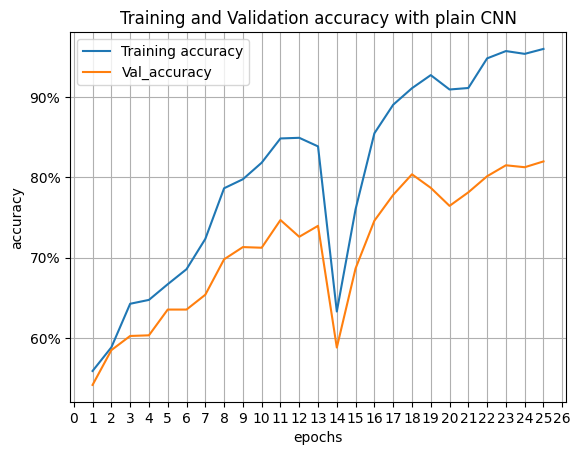

In [ ]:
epochs = np.arange(25) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_accuracies , label='Training accuracy')
plt.plot(epochs, val_accuracies, label='Val_accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation accuracy with plain CNN')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid('off')
plt.show()

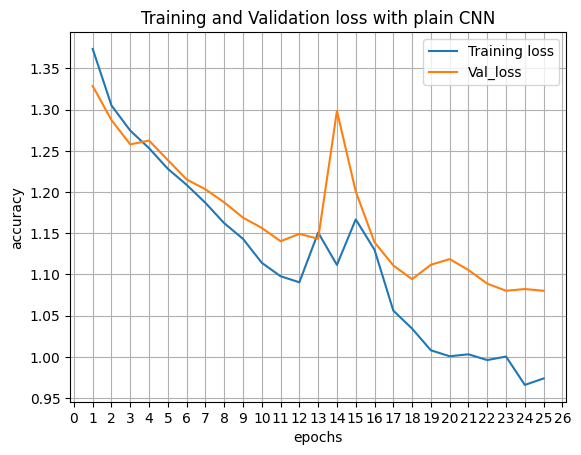

In [ ]:
epochs = np.arange(25) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_loss , label='Training loss')
plt.plot(epochs, val_loss, label='Val_loss')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation loss with plain CNN')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in plt.gca().get_yticks()])/
plt.grid('off')
plt.show()